In [1]:
import os
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from utl2 import dataset, ToTensor
from cnn_mlp import CNN_MLP
from cnn_lstm import CNN_LSTM
from resnet18 import Resnet18_MLP
from cnn_logical_v1_multiple_components_in_choice import CNN_Logical

In [2]:
class args():
    model='CNN_Logical'
    epochs=200
    batch_size=32
    seed=12345
    dataset = 'iRaven'
    device = 1
    load_workers = 16
    resume = False
    path = "/common/users/pv217/pritish_data"
    save = "/common/users/pv217/model_checkpoints/full_cnn_logical_multiple_eval/"
    img_size = 80
    lr = 1e-4
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8
    meta_alpha = 0.0
    meta_beta = 0.0
    cuda = torch.cuda.is_available()    

In [3]:
args.cuda = torch.cuda.is_available()
torch.cuda.set_device(args.device)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

In [4]:
data_path = "/common/users/pv217/pritish_data"

In [5]:
train = dataset(data_path, "train", args.img_size, transform=transforms.Compose([ToTensor()]),shuffle=True,
                rotate=False,vertical_flip=True, vertical_roll = False,
                horizontal_flip = True, horizontal_roll= False, max_rotate_angle = 180
               )
valid = dataset(data_path, "val", args.img_size, transform=transforms.Compose([ToTensor()]))
test = dataset(data_path, "test", args.img_size, transform=transforms.Compose([ToTensor()]))

In [6]:
trainloader = DataLoader(train, batch_size=args.batch_size, shuffle=True, num_workers=16)
validloader = DataLoader(valid, batch_size=args.batch_size, shuffle=False, num_workers=16)
testloader = DataLoader(test, batch_size=args.batch_size, shuffle=False, num_workers=16)

In [7]:
train.__getitem__(1)[2].shape

torch.Size([9])

In [8]:
train.__getitem__(1)[2].sum()

tensor(8.)

In [9]:
if args.model == "CNN_MLP":
    model = CNN_MLP(args)
elif args.model == "CNN_LSTM":
    model = CNN_LSTM(args)
elif args.model == "Resnet18_MLP":
    model = Resnet18_MLP(args)
elif args.model == "CNN_Logical":
    model = CNN_Logical(args)

In [10]:
if args.resume:
    model.load_model(args.save, 0)
    print('Loaded model')
if args.cuda:
    model = model.cuda()

In [11]:
def train(epoch):
    model.train()
    train_loss = 0
    accuracy = 0

    loss_all = 0.0
    acc_all = 0.0
    counter = 0
    for batch_idx, (image, target, meta_target) in enumerate(trainloader):
        counter += 1
        if args.cuda:
            image = image.cuda()
            target = target.cuda()
            meta_target = meta_target.cuda()
#             meta_structure = meta_structure.cuda()
#             embedding = embedding.cuda()
#             indicator = indicator.cuda()
        loss, acc = model.train_(image, target, meta_target)
        #print('Train: Epoch:{}, Batch:{}, Loss:{:.6f}, Acc:{:.4f}.'.format(epoch, batch_idx, loss, acc))
        loss_all += loss
        acc_all += acc
    print(epoch)
    if counter > 0:
        print("Avg Training Loss: {:.6f}".format(loss_all/float(counter)))
    return loss_all/float(counter), acc_all/float(counter)


In [12]:
def validate(epoch):
    model.eval()
    val_loss = 0
    accuracy = 0

    loss_all = 0.0
    acc_all = 0.0
    counter = 0
    for batch_idx, (image, target, meta_target) in enumerate(validloader):
        counter += 1
        if args.cuda:
            image = image.cuda()
            target = target.cuda()
            meta_target = meta_target.cuda()
#             meta_structure = meta_structure.cuda()
#             embedding = embedding.cuda()
#             indicator = indicator.cuda()
        loss, acc = model.validate_(image, target, meta_target)
        # print('Validate: Epoch:{}, Batch:{}, Loss:{:.6f}, Acc:{:.4f}.'.format(epoch, batch_idx, loss, acc)) 
        loss_all += loss
        acc_all += acc
    if counter > 0:
        print("Total Validation Loss: {:.6f}, Acc: {:.4f}".format(loss_all/float(counter), acc_all/float(counter)))
    return loss_all/float(counter), acc_all/float(counter)

In [13]:
def test(epoch):
    model.eval()
    accuracy = 0

    acc_all = 0.0
    counter = 0
    for batch_idx, (image, target, meta_target) in enumerate(testloader):
        counter += 1
        if args.cuda:
            image = image.cuda()
            target = target.cuda()
            meta_target = meta_target.cuda()
#             meta_structure = meta_structure.cuda()
#             embedding = embedding.cuda()
#             indicator = indicator.cuda()
        acc = model.test_(image, target, meta_target)
        # print('Test: Epoch:{}, Batch:{}, Acc:{:.4f}.'.format(epoch, batch_idx, acc))  
        acc_all += acc
    if counter > 0:
        print("Total Testing Acc: {:.4f}".format(acc_all / float(counter)))
    return acc_all/float(counter)

In [ ]:
epoch_lst = []
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []
test_acc_lst = []

for epoch in range(0, args.epochs):
    train_loss, train_acc = train(epoch)
    val_loss, val_acc = validate(epoch)
    test_acc = test(epoch)
    epoch_lst.append(epoch)
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)
    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)
    test_acc_lst.append(test_acc)
    model.save_model(args.save, epoch, val_acc, val_loss)
    
    

0
Avg Training Loss: 2.614998
Total Validation Loss: 2.337837, Acc: 12.9281
Total Testing Acc: 12.6284
1
Avg Training Loss: 2.322177
Total Validation Loss: 2.259788, Acc: 13.7343
Total Testing Acc: 13.7842
2
Avg Training Loss: 2.221158
Total Validation Loss: 2.140778, Acc: 16.9235
Total Testing Acc: 17.4658
3
Avg Training Loss: 2.143443
Total Validation Loss: 2.094168, Acc: 19.5420
Total Testing Acc: 19.0425
4
Avg Training Loss: 2.093492
Total Validation Loss: 2.029007, Acc: 21.8322
Total Testing Acc: 21.5040
5
Avg Training Loss: 2.033562
Total Validation Loss: 1.957442, Acc: 22.9523
Total Testing Acc: 22.8096
6
Avg Training Loss: 1.967106
Total Validation Loss: 1.888919, Acc: 25.8348
Total Testing Acc: 26.2914
7
Avg Training Loss: 1.912353
Total Validation Loss: 1.857889, Acc: 26.0274
Total Testing Acc: 26.3841
8
Avg Training Loss: 1.868389
Total Validation Loss: 1.809343, Acc: 27.8325
Total Testing Acc: 28.2677
9
Avg Training Loss: 1.834602
Total Validation Loss: 1.764474, Acc: 29.23

In [16]:
import pandas as pd
import seaborn as sns

In [17]:
training_stats = pd.DataFrame({'epoch':epoch_lst,
 'training_loss':train_loss_lst,
 'training_accuracy':train_acc_lst,
 'validation_loss':val_loss_lst,
 'validation_accuracy':val_acc_lst,
 'test_accuracy':test_acc_lst
})

In [18]:
training_stats = training_stats.set_index('epoch')

In [19]:
sns.set(rc = {'figure.figsize':(15,8)})

<AxesSubplot:xlabel='epoch'>

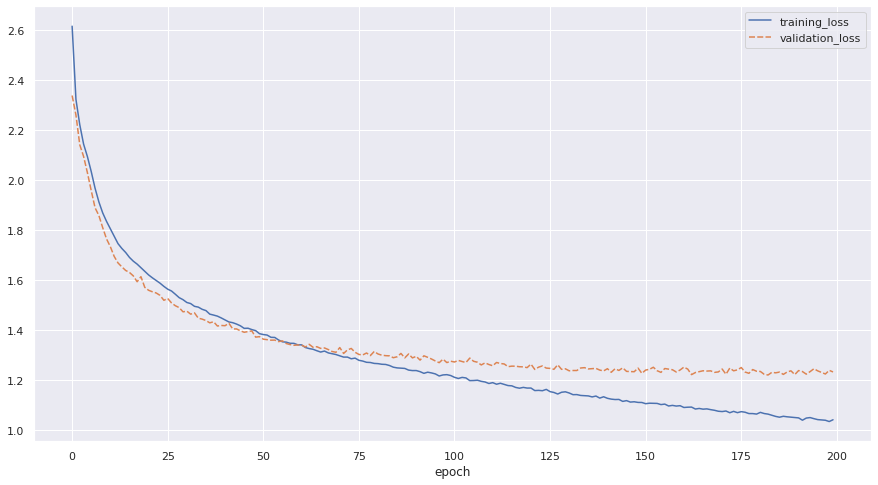

In [20]:
sns.lineplot(data=training_stats[['training_loss','validation_loss']])

<AxesSubplot:xlabel='epoch'>

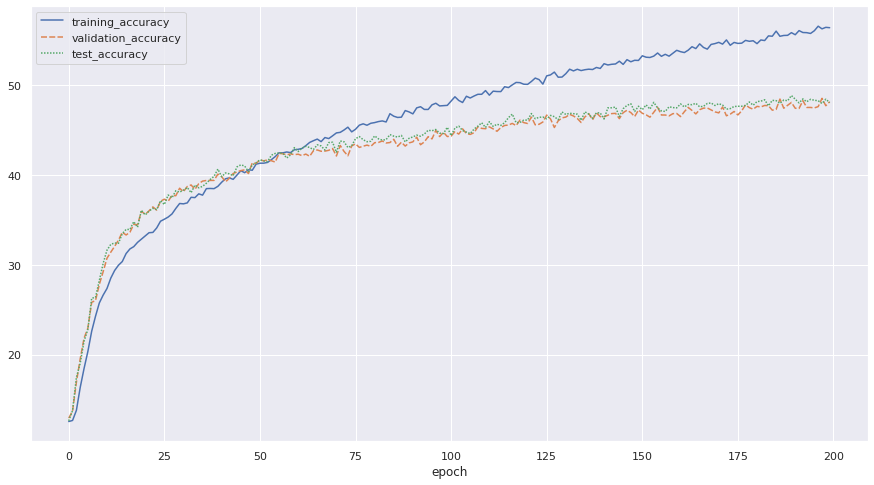

In [21]:
sns.lineplot(data=training_stats[['training_accuracy','validation_accuracy','test_accuracy']])

#### Checking Model performance on each configuration  

In [22]:
def validate():
    model.eval()
    val_loss = 0
    accuracy = 0
    epoch = 1
    loss_all = 0.0
    acc_all = 0.0
    counter = 0
    for batch_idx, (image, target, meta_target) in enumerate(validloader):
        counter += 1
#         print(counter)
        if args.cuda:
            image = image.cuda()
            target = target.cuda()
            meta_target = meta_target.cuda()
#             meta_structure = meta_structure.cuda()
        loss, acc = model.validate_(image, target, meta_target)
#         print('Validate: Epoch:{}, Batch:{}, Loss:{:.6f}, Acc:{:.4f}.'.format(epoch, batch_idx, loss, acc)) 
        loss_all += loss
        acc_all += acc
#         print(counter)
    if counter >0:
        print("Total Validation Loss: {:.6f}, Acc: {:.4f}".format(loss_all/float(counter), acc_all/float(counter)))
    return  acc_all/float(counter)

def test():
    model.eval()
    accuracy = 0
    epoch = 1
    acc_all = 0.0
    counter = 0
    for batch_idx, (image, target, meta_target) in enumerate(testloader):
        counter += 1
        if args.cuda:
            image = image.cuda()
            target = target.cuda()
            meta_target = meta_target.cuda()
#             meta_structure = meta_structure.cuda()
#             embedding = embedding.cuda()
#             indicator = indicator.cuda()
        acc = model.test_(image, target, meta_target)
        # print('Test: Epoch:{}, Batch:{}, Acc:{:.4f}.'.format(epoch, batch_idx, acc))  
        acc_all += acc
    if counter > 0:
        print("Total Testing Acc: {:.4f}".format(acc_all / float(counter)))
    return acc_all/float(counter)

In [23]:
config_lst = []
config_val_acc_list = []
config_test_acc_list = []
for i in ['/center_single/','/distribute_four/','/distribute_nine/',
          '/in_center_single_out_center_single/','/in_distribute_four_out_center_single/', 
          '/left_center_single_right_center_single/','/up_center_single_down_center_single/']:
    valid_dt = dataset(data_path, "val", args.img_size, transform=transforms.Compose([ToTensor()]))
    test_dt = dataset(data_path, "test", args.img_size, transform=transforms.Compose([ToTensor()]))
    valid_dt.file_names = [x for x in valid_dt.file_names if i in x]
    test_dt.file_names = [x for x in test_dt.file_names if i in x]
    validloader = DataLoader(valid_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)
    testloader = DataLoader(test_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)
    config_lst.append(i[1:-1])
    config_val_acc_list.append(validate())
    config_test_acc_list.append(test())
    
    

Total Validation Loss: 0.793913, Acc: 72.4702
Total Testing Acc: 72.4702
Total Validation Loss: 1.253744, Acc: 45.1885
Total Testing Acc: 45.8829
Total Validation Loss: 1.531205, Acc: 38.5913
Total Testing Acc: 37.4504
Total Validation Loss: 1.070646, Acc: 49.8512
Total Testing Acc: 50.7937
Total Validation Loss: 1.224203, Acc: 40.6250
Total Testing Acc: 41.8155
Total Validation Loss: 1.392743, Acc: 45.2381
Total Testing Acc: 43.5516
Total Validation Loss: 1.356454, Acc: 45.5853
Total Testing Acc: 44.6429


In [25]:
pd.DataFrame({'configuration':config_lst,'validation_accuracy':config_val_acc_list, 'test_accuracy':config_test_acc_list})

,configuration,validation_accuracy,test_accuracy
0,center_single,72.470238,72.470238
1,distribute_four,45.188492,45.882937
2,distribute_nine,38.591270,37.450397
3,in_center_single_out_center_single,49.851190,50.793651
4,in_distribute_four_out_center_single,40.625000,41.815476
5,left_center_single_right_center_single,45.238095,43.551587
6,up_center_single_down_center_single,45.585317,44.642857


<AxesSubplot:xlabel='configuration', ylabel='test_accuracy'>

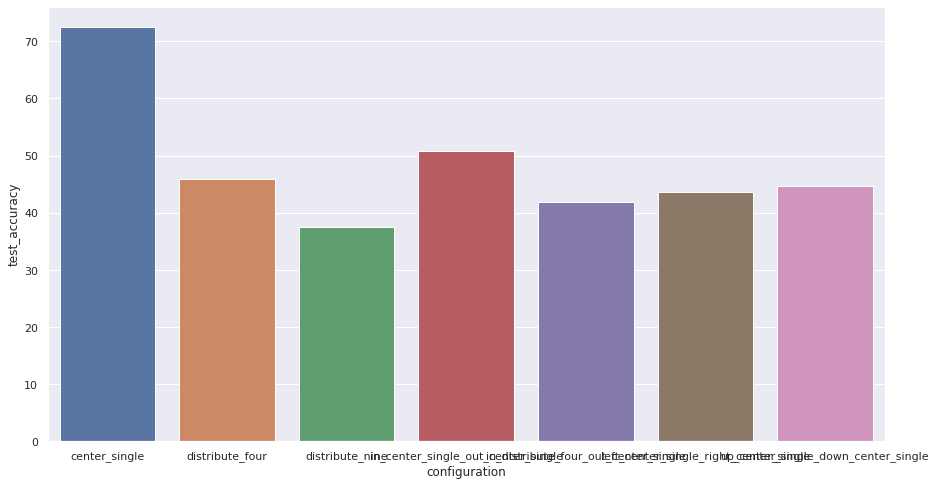

In [26]:
sns.barplot(x="configuration", y="test_accuracy", data=pd.DataFrame({'configuration':config_lst,'validation_accuracy':config_val_acc_list, 'test_accuracy':config_test_acc_list}))

In [ ]:
# sns.s pd.DataFrame({'configuration':config_lst,'validation_accuracy':config_val_acc_list, 'test_accuracy':config_test_acc_list}).set_index('configuration')

In [27]:
for i in ['/center_single/','/distribute_four/','/in_distribute_four_out_center_single/', '/left_center_single_right_center_single/']:
    train_dt = dataset(data_path, "train", args.img_size, transform=transforms.Compose([ToTensor()]))
    valid_dt = dataset(data_path, "val", args.img_size, transform=transforms.Compose([ToTensor()]))
    test_dt = dataset(data_path, "test", args.img_size, transform=transforms.Compose([ToTensor()]))
    train_dt.file_names = [x for x in train_dt.file_names if i in x]
    valid_dt.file_names = [x for x in valid_dt.file_names if i in x]
    test_dt.file_names = [x for x in test_dt.file_names if i in x]
    print(i,len(set(train_dt.file_names)),len(set(valid_dt.file_names)),len(set(test_dt.file_names)))


/center_single/ 6000 2000 2000
/distribute_four/ 6000 2000 2000
/in_distribute_four_out_center_single/ 6000 2000 2000
/left_center_single_right_center_single/ 6000 2000 2000


In [28]:
training_stats.tail(10)

,training_loss,training_accuracy,validation_loss,validation_accuracy,test_accuracy
epoch,,,,,
190,1.048833,55.638328,1.238174,47.445776,48.451769
191,1.039600,56.097677,1.234090,47.431507,48.045091
192,1.048145,55.885853,1.223784,48.294806,48.487443
193,1.050141,55.869193,1.233881,47.538527,48.173516
194,1.045813,55.781131,1.245302,47.538527,48.444635
195,1.041991,56.085777,1.236893,47.488584,48.337614
196,1.040560,56.590347,1.230554,47.631279,48.287671
197,1.039439,56.292841,1.224339,48.551655,47.980879
198,1.034317,56.461824,1.239005,47.731164,48.458904


In [29]:
from utl2 import dataset, ToTensor

In [30]:
# data_path_t = '/common/home/pv217/Downloads/Data-Color/'
test_dt = dataset(data_path, "test", args.img_size, transform=transforms.Compose([ToTensor()]),matrix=True)

test_dt.file_names = [x for x in test_dt.file_names if '/center_single/' in x]
testloader = DataLoader(test_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)


In [31]:
def test_ra_pairs_(model, image, target, ra_pair_matrix):
        with torch.no_grad():
            output = model(image)
        pred = output[0].data.max(1)[1]
        correct = pred.eq(target.data).cpu().sum().numpy()
        ra_pair_matrix_correct = pred.eq(target.data).cpu().numpy().reshape(-1,1,1)*ra_pair_matrix.numpy()
        accuracy = correct * 100.0 / target.size()[0]
        return accuracy, ra_pair_matrix_correct.sum(axis=0)

In [32]:
def test_ra_pairs():
#     model.eval()
    accuracy = 0
    epoch = 1
    acc_all = 0.0
    counter = 0
    data_ra_pairs = np.zeros((4,5))
    target_ra_pairs = np.zeros((4,5))
    for batch_idx, (image, target, meta_target,rule_attribute_matrix) in enumerate(testloader):
#         print(rule_attribute_matrix[10])
#         a = meta_matrix
        counter += 1
        data_ra_pairs += rule_attribute_matrix.sum(axis=0).numpy()
        
        if args.cuda:
            image = image.cuda()
            target = target.cuda()
            meta_target = meta_target.cuda()
#             meta_structure = meta_structure.cuda()
#             embedding = embedding.cuda()
#             indicator = indicator.cuda()
        
        acc,acc_ra_pairs = test_ra_pairs_(model,image, target, rule_attribute_matrix)
        # print('Test: Epoch:{}, Batch:{}, Acc:{:.4f}.'.format(epoch, batch_idx, acc))  
        target_ra_pairs +=acc_ra_pairs
        acc_all += acc
    if counter > 0:
        print("Total Testing Acc: {:.4f}".format(acc_all / float(counter)))
#     return rule_attribute_matrix
    return acc_all/float(counter),data_ra_pairs,target_ra_pairs

In [33]:
acc, data_ra_matrix, accurate_ra_matrix = test_ra_pairs()

Total Testing Acc: 72.4702


In [34]:
accurate_ra_matrix

array([[1448., 1448.,  506.,  462.,  378.],
       [   0.,    0.,  530.,  375.,  359.],
       [   0.,    0.,    0.,  273.,  378.],
       [   0.,    0.,  412.,  338.,  333.]])

In [35]:
data_ra_matrix

array([[2000., 2000.,  625.,  536.,  502.],
       [   0.,    0.,  696.,  456.,  484.],
       [   0.,    0.,    0.,  522.,  516.],
       [   0.,    0.,  679.,  486.,  498.]])

In [36]:
from matplotlib import pyplot as plt

/tmp/ipykernel_3351003/2072020424.py:3: RuntimeWarning: invalid value encountered in true_divide
  accuracy = accurate_ra_matrix/data_ra_matrix
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


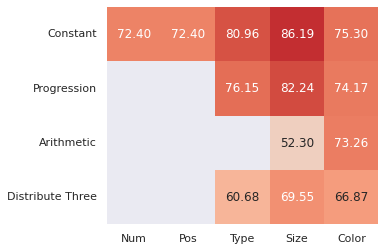

In [37]:
import seaborn as sns
%matplotlib inline
accuracy = accurate_ra_matrix/data_ra_matrix
Mask = np.zeros(np.shape(accuracy))
Mask[accuracy<=0.01] = 1
_accuracy = accuracy*100.0
midpoint = (_accuracy.max() - _accuracy.min()) / 2
# plot the heatmap
# plt.rcParams['font.size'] = 12
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(1)
sns.heatmap(_accuracy, 
            mask=Mask,
            vmin=0.0, vmax=90.0,
            #center = 45.0,
            cmap="coolwarm",
            square=True,
            robust=True,
            annot=True, fmt=".2f",annot_kws={'size':12},
            cbar=False,
        yticklabels=['Constant', 'Progression', 'Arithmetic', 'Distribute Three'],
        xticklabels=['Num', 'Pos', 'Type', 'Size', 'Color'])
# plt.xlabel('Attributes', fontsize=16)
# plt.ylabel('Rules', fontsize=16)
plt.savefig(f"heatmap_centersingle_i-raven.pdf", bbox_inches='tight', pad_inches=0)
# plt.text(5,12.3, "I-RAVEN", fontsize = 95, color='Black', fontstyle='italic')


In [38]:
# data_path_t = '/common/home/pv217/Downloads/Data-Color/'
test_dt = dataset(data_path, "test", args.img_size, transform=transforms.Compose([ToTensor()]),matrix=True)

# test_dt.file_names = [x for x in test_dt.file_names if '/center_single/' in x]
testloader = DataLoader(test_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)


In [39]:
acc, data_ra_matrix, accurate_ra_matrix = test_ra_pairs()

Total Testing Acc: 48.0665


/tmp/ipykernel_3351003/405861729.py:3: RuntimeWarning: invalid value encountered in true_divide
  accuracy = accurate_ra_matrix/data_ra_matrix


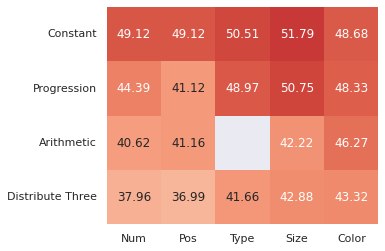

In [40]:
import seaborn as sns
%matplotlib inline
accuracy = accurate_ra_matrix/data_ra_matrix
Mask = np.zeros(np.shape(accuracy))
Mask[accuracy<=0.01] = 1
_accuracy = accuracy*100.0
midpoint = (_accuracy.max() - _accuracy.min()) / 2
# plot the heatmap
# plt.rcParams['font.size'] = 12
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(1)
sns.heatmap(_accuracy, 
            mask=Mask,
            vmin=0.0, vmax=55.0,
            #center = 45.0,
            cmap="coolwarm",
            square=True,
            robust=True,
            annot=True, fmt=".2f",annot_kws={'size':12},
            cbar=False,
        yticklabels=['Constant', 'Progression', 'Arithmetic', 'Distribute Three'],
        xticklabels=['Num', 'Pos', 'Type', 'Size', 'Color'])
# plt.xlabel('Attributes', fontsize=16)
# plt.ylabel('Rules', fontsize=16)
plt.savefig(f"heatmap_i-raven.pdf", bbox_inches='tight', pad_inches=0)
# plt.text(5,12.3, "I-RAVEN", fontsize = 95, color='Black', fontstyle='italic')
